In [1]:
import matplotlib.pyplot as plt # For general plotting
import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.model_selection import KFold


np.set_printoptions(suppress=True)

np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=12)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [2]:
def generate_data(N, alpha):  
    z_mu = np.zeros(10)
    z_sigma = alpha*np.diag(np.ones(10))

    x = mvn.rvs(x_mu, x_sigma, N)
    z = mvn.rvs(z_mu, z_sigma, N)
    v = mvn.rvs(0, 1, N)

    y = (a.T).dot((x + z).T) + v
    return x, y

def rss(w, X, y):
    predictions = X.dot(w)
    error = predictions - y
    return np.mean(error**2)

def map_loss(w, X, y, beta):
    regularizer = (1/beta) * np.linalg.norm(w, 2)
    loss_f = rss(w, X, y) + regularizer

    # Partial derivative for GD
    g = X.T.dot(X).dot(w) - X.T.dot(y) + (1/beta) * w

    return loss_f, g

In [3]:
# Breaks the matrix X and vector y into batches
def batchify(X, y, batch_size, N):
    X_batch = []
    y_batch = []

    # Iterate over N in batch_size steps, last batch may be < batch_size
    for i in range(0, N, batch_size):
        nxt = min(i + batch_size, N + 1)
        X_batch.append(X[i:nxt, :])
        y_batch.append(y[i:nxt])

    return X_batch, y_batch

def gradient_descent(loss_func, theta0, X, y, N, *args, **kwargs):
    # Mini-batch GD. Stochastic GD if batch_size=1.

    # Break up data into batches and work out gradient for each batch
    # Move parameters theta in that direction, scaled by the step size.

    # Options for total sweeps over data (max_epochs),
    # and parameters, like learning rate and threshold.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 10

    # Turn the data into batches
    X_batch, y_batch = batchify(X, y, batch_size, N)
    num_batches = len(y_batch)

    theta = theta0
    m_t = np.zeros(theta.shape)

    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        # print("epoch %d\n" % epoch)
        
        loss_epoch = 0
        for b in range(num_batches):
            X_b = X_batch[b]
            y_b = y_batch[b]
            # print("epoch %d batch %d\n" % (epoch, b))

            # Compute NLL loss and gradient of NLL function
            loss, gradient = loss_func(theta, X_b, y_b, *args)
            loss_epoch += loss
            
            # Steepest descent update
            theta = theta - alpha * gradient
            
            # Terminating Condition is based on how close we are to minimum (gradient = 0)
            if np.linalg.norm(gradient) < epsilon:
                break
                
        # Storing the history of the parameters and loss values per epoch
        trace['loss'].append(np.mean(loss_epoch))
        trace['theta'].append(theta)
        
        # Also break epochs loop
        if np.linalg.norm(gradient) < epsilon:
            break

    return theta, trace

In [4]:
def select_beta(x, y, plot_results=True):
    N = len(x)
    # Run CV for beta value
    K = 5
    kf = KFold(n_splits=K, shuffle=True) 
    betas = np.logspace(start=-3, stop=4, num=20, endpoint=True, base=10)
    print("Test betas: ")
    print(betas)

    # Allocate space for CV
    err_valid_mk = np.empty((len(betas), K)) 
    err_train_mk = np.empty((len(betas), K))

    for i in range(len(betas)):
        k = 0
        print(f"Testing beta: {betas[i]}")
        for train_indices, valid_indices in kf.split(x):
            # Extract the training and validation sets from the K-fold split
            x_train_k = x[train_indices]
            y_train_k = y[train_indices]
            x_valid_k = x[valid_indices]
            y_valid_k = y[valid_indices]
            
            # Find optimal parameters on the training set
            theta_gd, _ = gradient_descent(map_loss, theta0, x_train_k, y_train_k, N, betas[i], **opts)

            # Now with optimal theta for this iteration, find loss
            err_valid_mk[i, k] = rss(theta_gd, x_valid_k, y_valid_k)
            err_train_mk[i, k] = rss(theta_gd, x_train_k, y_train_k)
            k += 1

    # Find optimal model
    err_valid_m = np.mean(err_valid_mk, axis=1) 
    err_train_m = np.mean(err_train_mk, axis=1) 
    print("Validation error vector for beta values:")
    print(err_valid_m)

    optimal_beta = betas[np.argmin(err_valid_m)]
    print(f"Optimal beta: {optimal_beta}")

    if plot_results:
        # Plot error vs degree
        fig = plt.figure(figsize=(10, 10))
        plt.plot(betas, err_train_m, color="b", marker="s", label=r"$D_{train}$")
        plt.plot(betas, err_valid_m, color="r", marker="x", label=r"$D_{valid}$")
        plt.legend(loc='upper left', shadow=True)
        plt.xlabel("Beta Values")
        plt.ylabel("MSE")
        plt.xscale("log")
        plt.title("NLL estimates with {}-fold cross-validation".format(K))

    return optimal_beta

In [5]:
# Initial params for gradient descent
theta0 = np.random.randn(11)

# Data generation
a = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5])
x_mu = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
x_sigma = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

# Options for mini-batch gradient descent
opts = {}
opts['max_epoch'] = 1000
opts['alpha'] = 1e-3
opts['tolerance'] = 1e-3
opts['batch_size'] = 10

Test alpha values: 
[   0.001  111.112  222.223  333.334  444.445  555.556  666.667  777.778
  888.889 1000.   ]
Test betas: 
[    0.001          0.00233572     0.00545559     0.01274275
     0.02976351     0.06951928     0.16237767     0.37926902
     0.88586679     2.06913808     4.83293024    11.28837892
    26.36650899    61.58482111   143.84498883   335.98182863
   784.75997035  1832.98071083  4281.33239872 10000.        ]
Testing beta: 0.001


C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Testing beta: 0.002335721469090121
Testing beta: 0.00545559478116852
Testing beta: 0.012742749857031334
Testing beta: 0.029763514416313176
Testing beta: 0.06951927961775606
Testing beta: 0.1623776739188721
Testing beta: 0.37926901907322497
Testing beta: 0.8858667904100823
Testing beta: 2.069138081114788
Testing beta: 4.832930238571752
Testing beta: 11.288378916846883
Testing beta: 26.366508987303554
Testing beta: 61.58482110660255
Testing beta: 143.8449888287663
Testing beta: 335.9818286283781
Testing beta: 784.7599703514607
Testing beta: 1832.9807108324337
Testing beta: 4281.332398719387
Testing beta: 10000.0
Validation error vector for beta values:
[4491.90234116 2190.51555153  753.91540874  196.42984101   46.71505965
   10.68162539    3.38875556    1.77675881    1.33258099    1.22601306
    1.16852053    1.13847553    1.24327334    1.15678581    1.22567744
    1.25256336    1.2034764     1.23446203    1.19467392   26.25998964]
Optimal beta: 11.288378916846883
Test betas: 
[    0.001

Testing beta: 0.37926901907322497
Testing beta: 0.8858667904100823
Testing beta: 2.069138081114788
Testing beta: 4.832930238571752
Testing beta: 11.288378916846883
Testing beta: 26.366508987303554
Testing beta: 61.58482110660255
Testing beta: 143.8449888287663
Testing beta: 335.9818286283781
Testing beta: 784.7599703514607
Testing beta: 1832.9807108324337
Testing beta: 4281.332398719387
Testing beta: 10000.0
Validation error vector for beta values:
[62560.95988006 69874.26143322 69741.24915034 66188.73208154
 73873.45659305 65138.63962344 78079.37802953 79846.7710385
 70601.89577842 72899.59730371 68131.49406288 71170.8347596
 84165.76771709 72242.52726156 70047.71508806 69911.83343394
 67371.40578903 78999.41927864 69223.70700419 67806.40096365]
Optimal beta: 0.001
Test betas: 
[    0.001          0.00233572     0.00545559     0.01274275
     0.02976351     0.06951928     0.16237767     0.37926902
     0.88586679     2.06913808     4.83293024    11.28837892
    26.36650899    61.58482

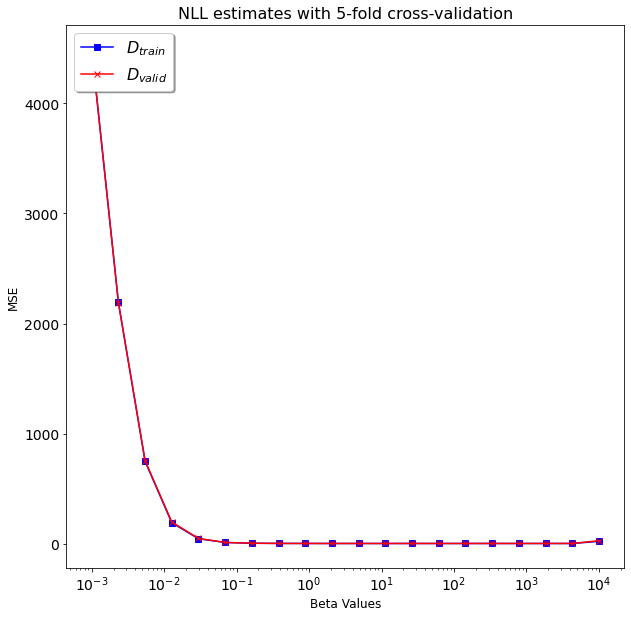

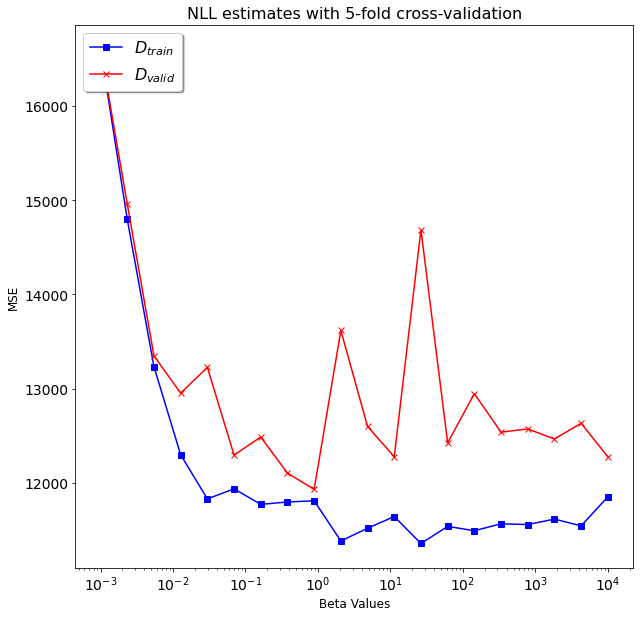

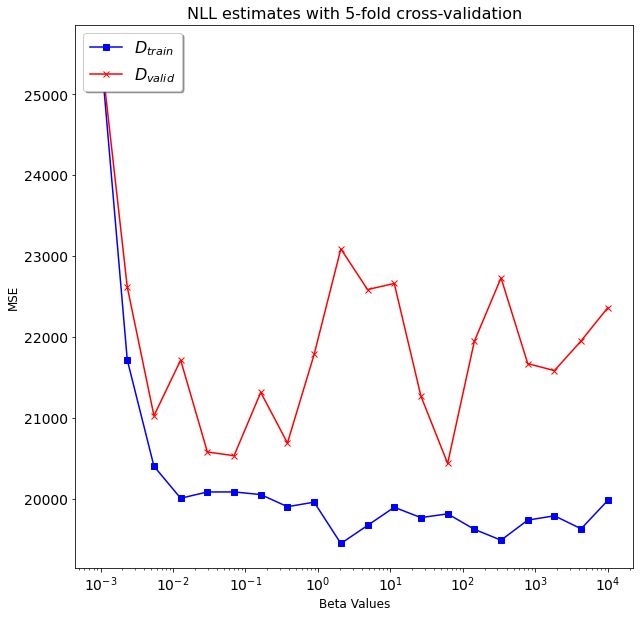

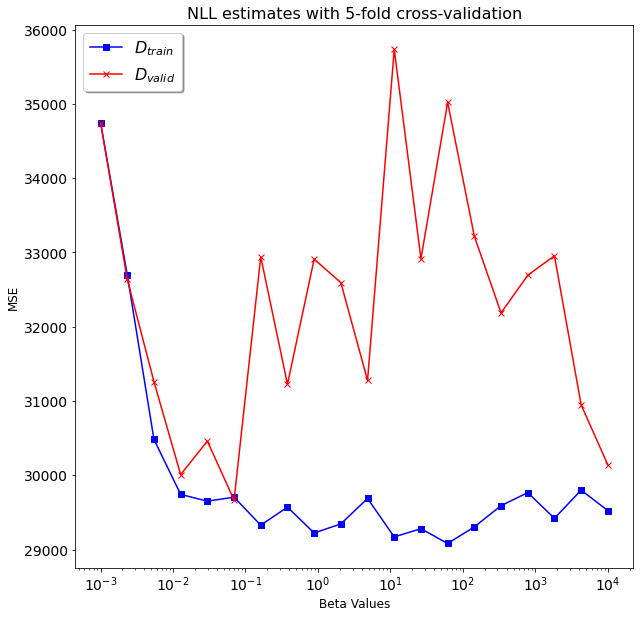

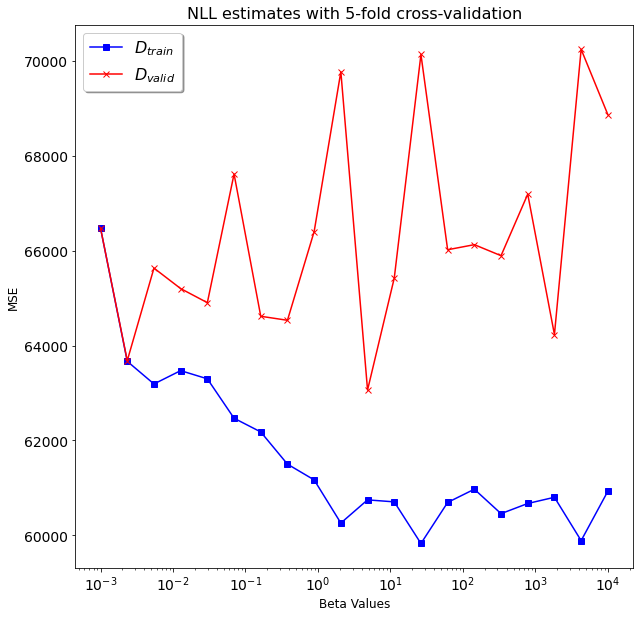

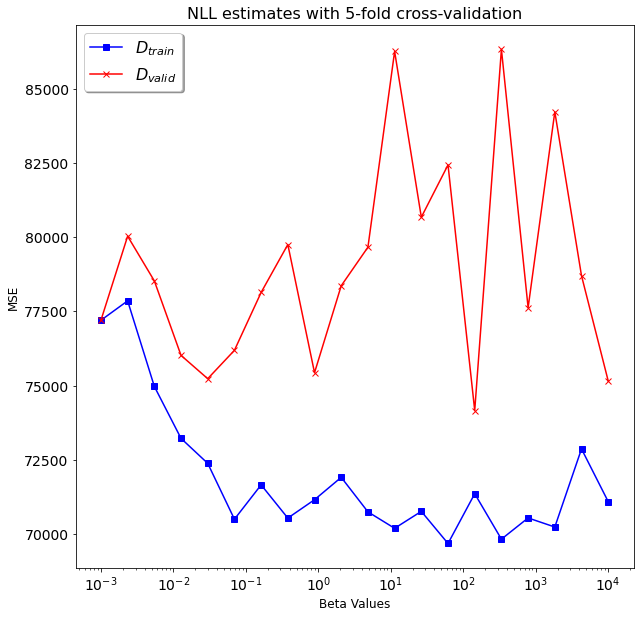

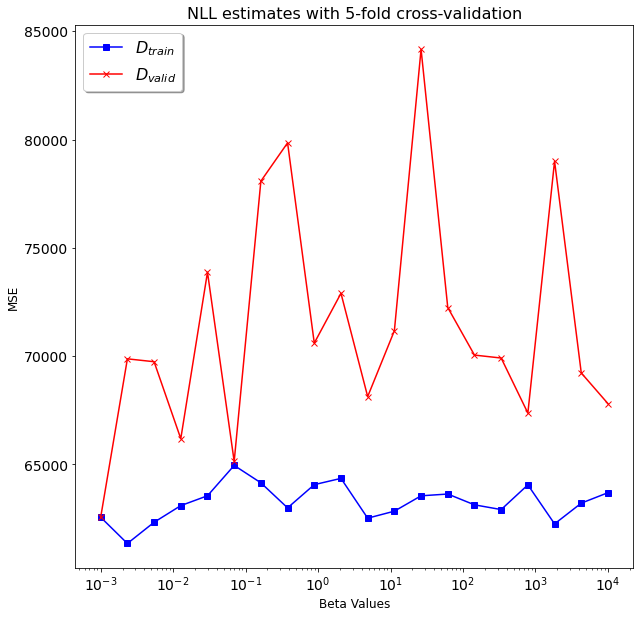

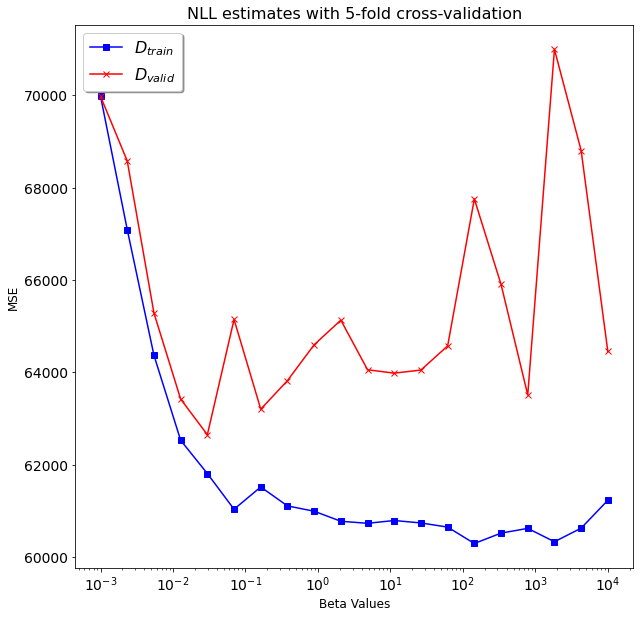

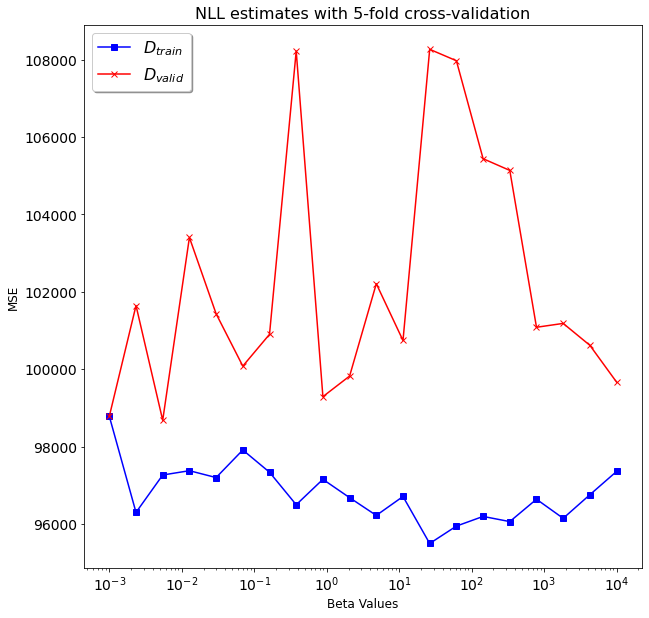

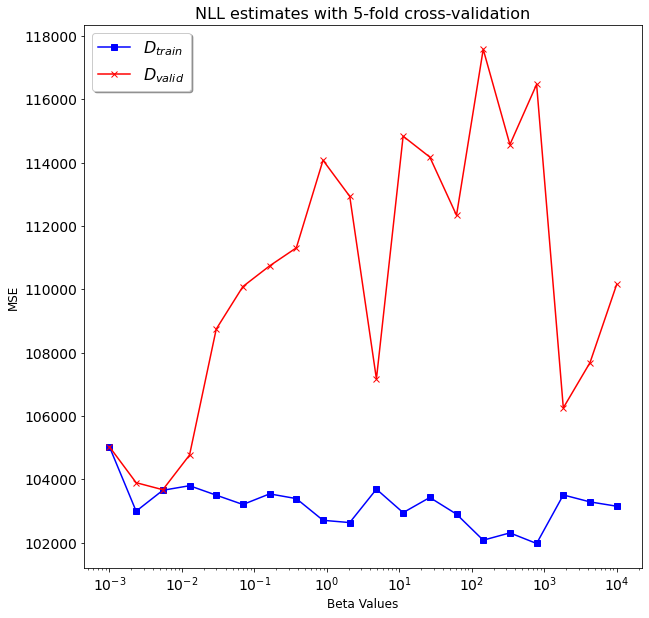

In [6]:
%matplotlib inline

# Sample sizes
N_train = 50
N_test = 1000

# Noise variation
alphas = np.linspace(0.001, 1000, 10) * np.trace(x_sigma) / 10
print("Test alpha values: ")
print(alphas)

optimal_betas = []
model_params = []
performances = []

for alpha in alphas:
    x_train, y_train = generate_data(N_train, alpha)
    x_test, y_test = generate_data(N_test, alpha)

    # Create augmented inputs x
    x_train = np.column_stack((np.ones(N_train), x_train))
    x_test = np.column_stack((np.ones(N_test), x_test))

    # Run CV for optimal beta value
    optimal_beta = select_beta(x_train, y_train)
    optimal_betas.append(optimal_beta)

    # Find the optimal model using the found beta value
    theta_gd, _ = gradient_descent(map_loss, theta0, x_train, y_train, N_train, optimal_beta, **opts)
    model_params.append(theta_gd)

    # Predictions based on trained params
    performance = rss(theta_gd, x_test, y_test)
    performances.append(performance)

print("Optimal betas:")
print(optimal_betas)
print("Model Params:")
print(model_params)
print("Performances(-2*LL):")
print(performances)
plt.show()